# **Предсказание задержки рейса**

## Импорт зависимостей

In [10]:
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from catboost import CatBoostRegressor, CatBoostClassifier

from sklearn.model_selection import *
from sklearn.metrics import *

pd.options.display.float_format = "{:.1f}".format
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight") 

import warnings
warnings.filterwarnings("ignore")

## Загрузка данных

In [11]:
df = pd.read_csv('data/flights.csv')
print('Dataframe dimensions:', df.shape, '\n')
df.head()

Dataframe dimensions: (5819079, 31) 



,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

Так как данные весьма объемные, рассмотрим только 1 месяц - Январь.

In [13]:
df = df[df.MONTH == 1].reset_index(drop=True)

Каждая строка `flights.csv` содержит информацию об одном перелете. Всего 5'800'000 полетов за 2015 год. Датасет состоит из 31 признака.

- **YEAR, MONTH, DAY, DAY_OF_WEEK**: даты перелета <br/>
- **AIRLINE**: идентификационный номер авиакомпании<br/>
- **ORIGIN_AIRPORT** и **DESTINATION_AIRPORT**: код аэропортов отбытия и прибытия <br/>
- **SCHEDULED_DEPARTURE** и **SCHEDULED_ARRIVAL** : время вылета и прилета по расписанию <br/> 
- **DEPARTURE_TIME** и **ARRIVAL_TIME**: реальное время взлета и посадки <br/> 
- **DEPARTURE_DELAY** и **ARRIVAL_DELAY**: разница между реальным и запланированным временем (задержка) <br/> 
- **DISTANCE**: расстояние перелета (в милях)  <br/>

Дополнительный файл `airports.csv` содержит информацию об аэропортах.

In [14]:
airports = pd.read_csv('data/airports.csv')
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.7,-75.4
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.4,-99.7
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.0,-106.6
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.4,-98.4
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.5,-84.2


Дополнительный файл `airlines.csv` содержит информацию об авиакомпаниях.

In [15]:
airlines_names = pd.read_csv('data/airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


Для дальнейшего использования понадобится словарик перевода кода компании в название.

In [16]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

## Первичные преобразования

Переведем формат **YEAR, MONTH, DAY**, **DAY_OF_WEEK** в единый **_datetime_**.


In [17]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

Также нам нужно преобразовать переменные реального и планируемого времени вылета и прилета.

In [18]:
#_________________________________________________________
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
#_____________________________________________________________________
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#_______________________________________________________________________________
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

In [19]:
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)

Посмотрим переменные, которые нам нужны для создания таргета.

In [20]:
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


Создадим таргеты. В рамках данной задачи рассмотрим только задержку вылета и факт задержки более чем на 5 минут. При этом факт задержки предсказываем только для опоздания вылета, а не для более раннего вылета.

In [21]:
df['5min_DELAY'] = df.DEPARTURE_DELAY.apply(lambda x: x > 5).astype(int)
df['5min_DELAY']

0         0
1         0
2         0
3         0
4         0
         ..
469963    0
469964    0
469965    0
469966    0
469967    0
Name: 5min_DELAY, Length: 469968, dtype: int64

Удалим признаки, которые не будем рассматривать в данном разборе.

In [22]:
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
         'SCHEDULED_TIME', 'ELAPSED_TIME',
         'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 
         'DEPARTURE_DELAY', '5min_DELAY']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_TIME,ELAPSED_TIME,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,5min_DELAY
0,AS,ANC,SEA,205.0,194.0,2015-01-01 00:05:00,23:54:00,-11.0,0
1,AA,LAX,PBI,280.0,279.0,2015-01-01 00:10:00,00:02:00,-8.0,0
2,US,SFO,CLT,286.0,293.0,2015-01-01 00:20:00,00:18:00,-2.0,0
3,AA,LAX,MIA,285.0,281.0,2015-01-01 00:20:00,00:15:00,-5.0,0
4,AS,SEA,ANC,235.0,215.0,2015-01-01 00:25:00,00:24:00,-1.0,0


## Исследовательский анализ данных

### Пропущенные значения

In [23]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ELAPSED_TIME,12955,97.2
1,DEPARTURE_TIME,11657,97.5
2,DEPARTURE_DELAY,11657,97.5
3,AIRLINE,0,100.0
4,ORIGIN_AIRPORT,0,100.0
5,DESTINATION_AIRPORT,0,100.0
6,SCHEDULED_TIME,0,100.0
7,SCHEDULED_DEPARTURE,0,100.0
8,5min_DELAY,0,100.0


Так как мы не можем предсказывать пустой таргет, удалим его. И удалим случаи отрицательной задержки вылета, то есть вылет осуществлен раньше времени.

In [24]:
df = df[(df.DEPARTURE_DELAY >= 0)&(df.DEPARTURE_DELAY.notnull())].reset_index(drop=True)

### Анализ таргетов

In [25]:
df.DEPARTURE_DELAY.describe()

count   200912.0
mean        28.7
std         49.1
min          0.0
25%          3.0
50%         12.0
75%         34.0
max       1988.0
Name: DEPARTURE_DELAY, dtype: float64

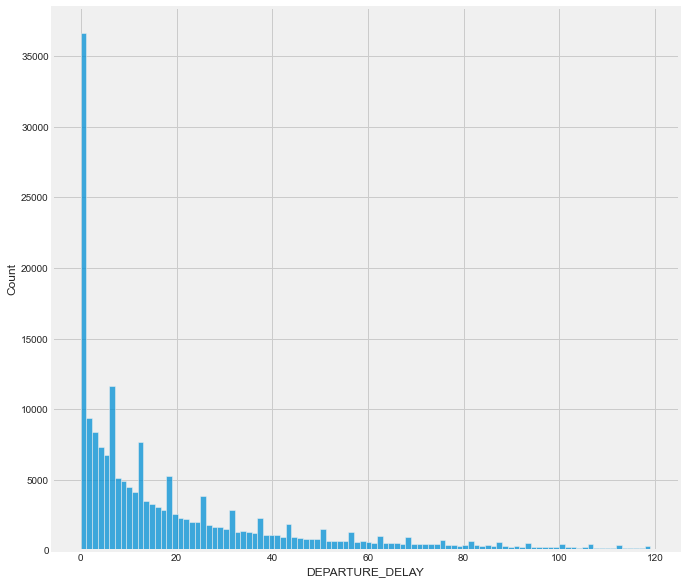

In [32]:
plt.subplots(figsize=(10, 10))
sns.histplot(df[df.DEPARTURE_DELAY < 120].DEPARTURE_DELAY, bins=100)
plt.show()

In [33]:
df['5min_DELAY'].value_counts()

1    132389
0     68523
Name: 5min_DELAY, dtype: int64

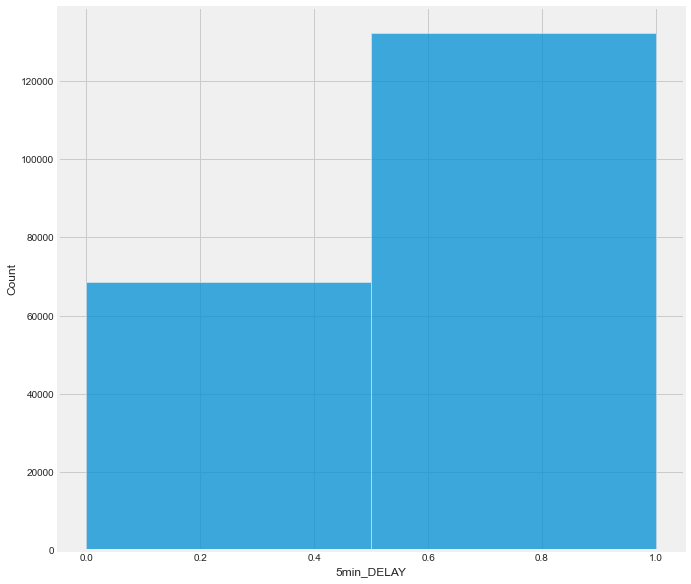

In [34]:
plt.subplots(figsize=(10, 10))
sns.histplot(df['5min_DELAY'], bins=2)
plt.show()

### Посмотрим зависимость таргета от авиакомпании

In [35]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
AIRLINE,,,,
VX,0.0,397.0,1858.0,24.7
HA,0.0,1003.0,2111.0,15.8
F9,0.0,696.0,3210.0,45.6
NK,0.0,557.0,4043.0,35.1
AS,0.0,538.0,4181.0,25.4
B6,0.0,500.0,8835.0,31.1
US,0.0,638.0,11528.0,23.8
MQ,0.0,780.0,13658.0,38.1
EV,0.0,726.0,17832.0,36.3


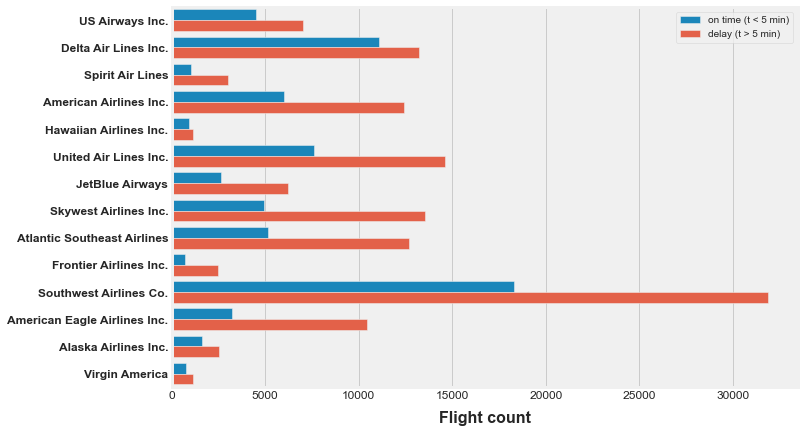

In [36]:
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='5min_DELAY', data=df)

labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)

L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('delay (t > 5 min)')
plt.show()

### Зависимость таргета от аэропорта

In [37]:
print("Количество аэропортов: {}".format(len(df['ORIGIN_AIRPORT'].unique())))

Количество аэропортов: 312


Сколько разных аэропортов посещают авиакомпании

In [38]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(liste_origin_airport)

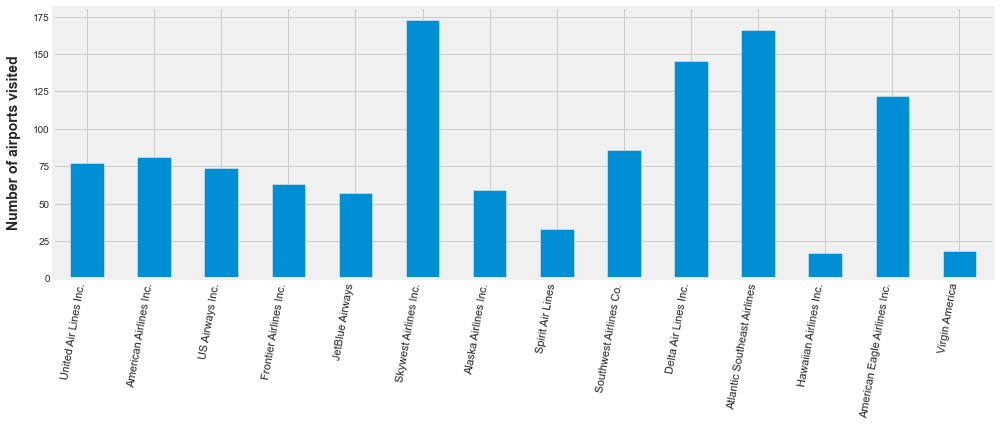

In [41]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (15,5))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

Хитмап задержки рейса в зависимости от аэропорта и авиакомпании

In [48]:
temp = pd.read_csv('data/airports.csv')
identify_airport = temp.set_index('IATA_CODE')['CITY'].to_dict()
latitude_airport = temp.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = temp.set_index('IATA_CODE')['LONGITUDE'].to_dict()

In [49]:
airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in abbr_companies.keys():
    df1 = df[df['AIRLINE'] == carrier]
    test = df1['DEPARTURE_DELAY'].groupby(df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

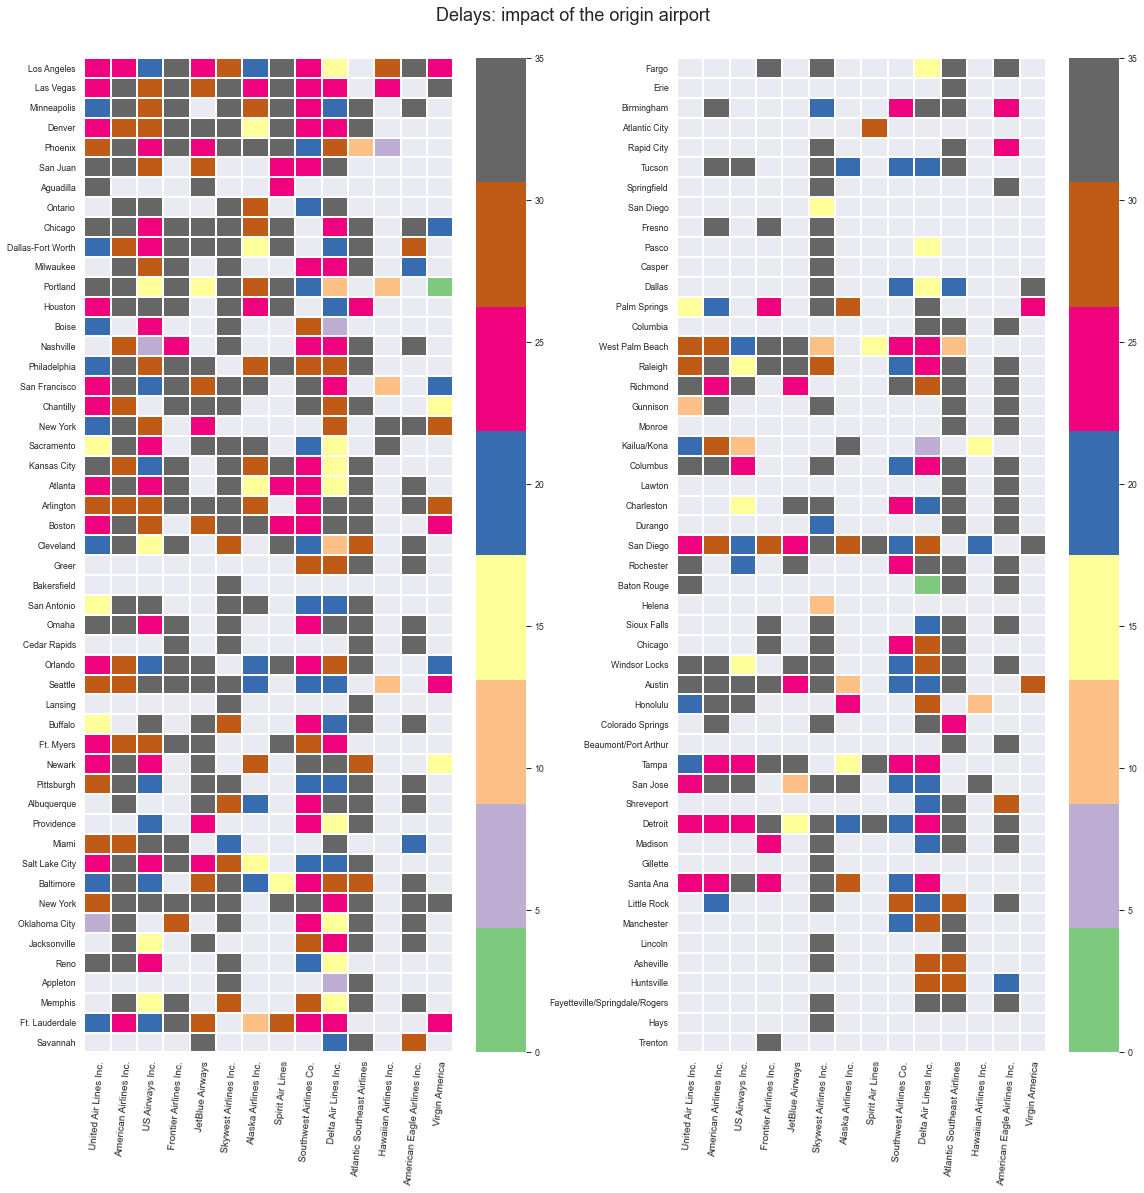

In [51]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(16,16))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

### Существуют ли рейсы, которые всегда задерживают?

In [55]:
df2 = df[df.AIRLINE == 'AA'][['DEPARTURE_DELAY']]
df2['ROUTE'] = df[df.AIRLINE == 'AA']['ORIGIN_AIRPORT'] + '-' + df[df.AIRLINE == 'AA']['DESTINATION_AIRPORT']

In [57]:
df2.groupby('ROUTE').DEPARTURE_DELAY.describe().sort_values('min', ascending=False)

,count,mean,std,min,25%,50%,75%,max
ROUTE,,,,,,,,
TUL-ORD,2.0,38.5,3.5,36.0,37.2,38.5,39.8,41.0
MTJ-DFW,3.0,41.7,11.4,29.0,37.0,45.0,48.0,51.0
MIA-TUL,2.0,27.5,10.6,20.0,23.8,27.5,31.2,35.0
STT-JFK,9.0,131.8,104.1,17.0,43.0,100.0,209.0,316.0
PHL-CLT,6.0,269.7,461.5,13.0,46.2,100.0,153.8,1205.0
...,...,...,...,...,...,...,...,...
EGE-JFK,10.0,61.5,74.3,0.0,3.8,18.5,125.0,178.0
EGE-DFW,26.0,100.7,235.7,0.0,12.2,31.5,68.0,1190.0
DTW-MIA,22.0,20.8,42.0,0.0,3.2,9.0,25.2,200.0


## Подготовка данных к обучению моделей

### Разбиение на трейн и финальный тест

In [156]:
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2015, 1, 23)]
df_train = df_train.drop(['DEPARTURE_TIME'], axis=1).reset_index(drop=True)

df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2015, 1, 23)]
df_test = df_test.drop(['DEPARTURE_TIME'], axis=1).reset_index(drop=True)

In [157]:
print('Train shape:', df_train.shape)
print('Test shape:', df_test.shape)

Train shape: (157629, 8)
Test shape: (37544, 8)


### Генерация фичей

Признаки даты и времени

In [158]:
df_train['month'] = df_train.SCHEDULED_DEPARTURE.apply(lambda x: x.month)
df_train['day'] = df_train.SCHEDULED_DEPARTURE.apply(lambda x: x.day)
df_train['weekday'] = df_train.SCHEDULED_DEPARTURE.apply(lambda x: x.weekday())
df_train['hour'] = df_train.SCHEDULED_DEPARTURE.apply(lambda x: x.hour)
df_train['minute'] = df_train.SCHEDULED_DEPARTURE.apply(lambda x: x.minute)

df_test['month'] = df_test.SCHEDULED_DEPARTURE.apply(lambda x: x.month)
df_test['day'] = df_test.SCHEDULED_DEPARTURE.apply(lambda x: x.day)
df_test['weekday'] = df_test.SCHEDULED_DEPARTURE.apply(lambda x: x.weekday())
df_test['hour'] = df_test.SCHEDULED_DEPARTURE.apply(lambda x: x.hour)
df_test['minute'] = df_test.SCHEDULED_DEPARTURE.apply(lambda x: x.minute)

df_train[['month', 'day', 'weekday', 'hour', 'minute']].head()

,month,day,weekday,hour,minute
0,1,1,3,0,30
1,1,1,3,0,30
2,1,1,3,0,35
3,1,1,3,0,55
4,1,1,3,1,15


Создание категориального признака: маршрут из аэропорта вылета и прибытия + авиакомпания

In [159]:
df_train['route'] = df_train['ORIGIN_AIRPORT'] + '-' + df_train['DESTINATION_AIRPORT']
df_train['route_airline'] = df_train['AIRLINE'] + '/' + df_train['route']

df_test['route'] = df_test['ORIGIN_AIRPORT'] + '-' + df_test['DESTINATION_AIRPORT']
df_test['route_airline'] = df_test['AIRLINE'] + '/' + df_test['route']

df_train[['route', 'route_airline']].head()

,route,route_airline
0,LAX-CLT,US/LAX-CLT
1,LAS-ATL,DL/LAS-ATL
2,LAX-MSP,DL/LAX-MSP
3,LAS-MCI,NK/LAS-MCI
4,MSP-FLL,NK/MSP-FLL


Добавление исторических признаков

In [160]:
df_train.route.nunique()

4115

In [161]:
df_train.route_airline.nunique()

6327

Так как уникальных маршрутов получилось очень много и этот признак будет сложно использовать как категориальный, то можно преобразовать категориальный признак в исторические статистики этого признака.

In [162]:
temp = df_train.groupby('route_airline').DEPARTURE_DELAY.describe().reset_index()

In [163]:
temp.head()

,route_airline,count,mean,std,min,25%,50%,75%,max
0,AA/ABQ-DFW,29.0,31.8,91.7,0.0,2.0,8.0,17.0,499.0
1,AA/ATL-DFW,83.0,35.9,60.1,0.0,5.0,15.0,45.5,431.0
2,AA/ATL-MIA,19.0,24.0,37.5,0.0,1.5,10.0,26.5,147.0
3,AA/AUS-DFW,106.0,42.8,145.5,0.0,4.0,14.0,38.5,1450.0
4,AA/AUS-JFK,6.0,42.3,44.6,1.0,8.2,30.5,66.2,113.0


In [164]:
df_train = pd.merge(df_train, temp[['route_airline', 'mean', 'min', 'max']],
                    on='route_airline', how='left')
df_test = pd.merge(df_test, temp[['route_airline', 'mean', 'min', 'max']],
                    on='route_airline', how='left')

In [165]:
df_train.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_TIME,ELAPSED_TIME,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,5min_DELAY,month,day,weekday,hour,minute,route,route_airline,mean,min,max
0,US,LAX,CLT,273.0,249.0,2015-01-01 00:30:00,14.0,1,1,1,3,0,30,LAX-CLT,US/LAX-CLT,16.6,0.0,140.0
1,DL,LAS,ATL,221.0,203.0,2015-01-01 00:30:00,3.0,0,1,1,3,0,30,LAS-ATL,DL/LAS-ATL,12.8,0.0,143.0
2,DL,LAX,MSP,214.0,210.0,2015-01-01 00:35:00,0.0,0,1,1,3,0,35,LAX-MSP,DL/LAX-MSP,15.4,0.0,75.0
3,NK,LAS,MCI,162.0,143.0,2015-01-01 00:55:00,25.0,1,1,1,3,0,55,LAS-MCI,NK/LAS-MCI,34.2,1.0,70.0
4,NK,MSP,FLL,207.0,220.0,2015-01-01 01:15:00,12.0,1,1,1,3,1,15,MSP-FLL,NK/MSP-FLL,36.8,8.0,114.0


In [166]:
df_train = df_train.drop(['route'], axis=1)
df_test = df_test.drop(['route'], axis=1)

Так как в качестве модели мы будем использовать CatBoost, можем оставить признак __route_airline__ как текстовый.

In [167]:
df_train['route_airline'] = df_train['route_airline'].apply(lambda x: x.replace('/', ' ').replace('-', ' '))
df_test['route_airline'] = df_test['route_airline'].apply(lambda x: x.replace('/', ' ').replace('-', ' '))

### Преобразованиие данных в X и y

In [168]:
X = df_train.drop(['SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY', '5min_DELAY'], axis=1)
y_regression = df_train['DEPARTURE_DELAY']
y_classification = df_train['5min_DELAY']

cat_features = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'day', 'weekday', 'hour']
text_features = ['route_airline']

X_test = df_test.drop(['SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY', '5min_DELAY'], axis=1)
y_test_regression = df_test['DEPARTURE_DELAY']
y_test_classification = df_test['5min_DELAY']

## Обучение и тестирование моделей

### Подход №1: Регрессия моделью + классификация по условию

In [142]:
X_train, X_val, y_train, y_val = train_test_split(X.drop(text_features, axis=1), 
                                                  y_regression, 
                                                  test_size=0.15, random_state=17)

In [143]:
model_regression = CatBoostRegressor(
    verbose=100,
    cat_features=cat_features
)

model_regression.fit(X_train, y_train, eval_set=(X_val, y_val))

Learning rate set to 0.116279
0:	learn: 48.8862822	test: 53.2194914	best: 53.2194914 (0)	total: 40.4ms	remaining: 40.4s
100:	learn: 44.7589872	test: 49.2935014	best: 49.2765609 (92)	total: 5.44s	remaining: 48.4s
200:	learn: 44.0794688	test: 49.1830878	best: 49.1830878 (200)	total: 10.9s	remaining: 43.3s
300:	learn: 43.6265353	test: 49.1257910	best: 49.1204494 (286)	total: 16.7s	remaining: 38.7s
400:	learn: 43.2599619	test: 49.0751962	best: 49.0676076 (394)	total: 22.1s	remaining: 33.1s
500:	learn: 42.9280566	test: 49.0959378	best: 49.0504719 (421)	total: 27.6s	remaining: 27.5s
600:	learn: 42.6112853	test: 49.0938183	best: 49.0504719 (421)	total: 33.5s	remaining: 22.2s
700:	learn: 42.3259333	test: 49.1087438	best: 49.0504719 (421)	total: 39.3s	remaining: 16.8s
800:	learn: 42.0311405	test: 49.0965007	best: 49.0504719 (421)	total: 45.1s	remaining: 11.2s
900:	learn: 41.7608538	test: 49.1256753	best: 49.0504719 (421)	total: 51s	remaining: 5.6s
999:	learn: 41.5289437	test: 49.1357711	best: 4

In [144]:
preds_test_regression = model_regression.predict(X_test[model_regression.feature_names_])
preds_test_classification = (preds_test_regression > 5).astype(int)

In [145]:
print('Test MAE:', mean_absolute_error(y_test_regression, preds_test_regression))
print('Test Accuracy:', accuracy_score(y_test_classification, preds_test_classification))

Test MAE: 24.814202144431352
Test Accuracy: 0.5970328148305988


### Подход №2: Регрессия моделью + классификация моделью

Модель для регрессии у нас уже есть

In [146]:
# model_regression

In [169]:
X_train, X_val, y_train, y_val = train_test_split(X, y_classification, 
                                                  test_size=0.15, 
                                                  stratify=y_classification,
                                                  random_state=17)

In [170]:
# .drop(text_features, axis=1)

In [171]:
model_classification = CatBoostClassifier(
    verbose=100,
    cat_features=cat_features,
    text_features=text_features
)

model_classification.fit(X_train, y_train, eval_set=(X_val, y_val))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.106241
0:	learn: 0.6726016	test: 0.6724077	best: 0.6724077 (0)	total: 142ms	remaining: 2m 21s
100:	learn: 0.5660289	test: 0.5660813	best: 0.5660801 (98)	total: 16s	remaining: 2m 22s
200:	learn: 0.5584408	test: 0.5620302	best: 0.5620287 (199)	total: 31.6s	remaining: 2m 5s
300:	learn: 0.5535594	test: 0.5606054	best: 0.5605813 (297)	total: 46.7s	remaining: 1m 48s
400:	learn: 0.5496079	test: 0.5597471	best: 0.5597391 (399)	total: 1m 1s	remaining: 1m 31s
500:	learn: 0.5460255	test: 0.5588424	best: 0.5588424 (500)	total: 1m 15s	remaining: 1m 15s
600:	learn: 0.5429170	test: 0.5588146	best: 0.5587549 (513)	total: 1m 29s	remaining: 59.6s
700:	learn: 0.5400340	test: 0.5585412	best: 0.5585412 (700)	total: 1m 43s	remaining: 44.1s
800:	learn: 0.5372140	test: 0.5585952	best: 0.5584446 (720)	total: 1m 57s	remaining: 29.2s
900:	learn: 0.5342704	test: 0.5583211	best: 0.5583152 (899)	total: 2m 11s	remaining: 14.4s
999:	learn: 0.5317608	test: 0.5582386	best: 0.5582319 (996)	total: 

In [173]:
preds_test_regression = model_regression.predict(X_test[model_regression.feature_names_])
preds_test_classification = model_classification.predict(X_test[model_classification.feature_names_])

In [174]:
print('Test MAE:', mean_absolute_error(y_test_regression, preds_test_regression))
print('Test Accuracy:', accuracy_score(y_test_classification, preds_test_classification))

Test MAE: 24.814202144431352
Test Accuracy: 0.6000159812486683


### Подход №3: Регрессия моделью + классификация моделью + ансамбль

In [ ]:
regression_models = []
classification_models = []

preds_test_regression_ = []
preds_test_classification_ = []

for train_index, val_index in StratifiedKFold(n_splits=5).split(X, y_regression):
    
    X_train_regression = X.drop(text_features, axis=1).iloc[train_index]
    X_val_regression = X.drop(text_features, axis=1).iloc[val_index]
    y_train_regression = y_regression.iloc[train_index]
    y_val_regression = y_regression.iloc[val_index]
    
    X_train_classification = X.iloc[train_index]
    X_val_classification = X.iloc[val_index]
    y_train_classification = y_classification.iloc[train_index]
    y_val_classification = y_classification.iloc[val_index]
    
    model_regression = CatBoostRegressor(
        verbose=1000,
        cat_features=cat_features
    )
    model_regression.fit(X_train_regression, y_train_regression, 
                         eval_set=(X_val_regression, y_val_regression))
    regression_models.append(model_regression)
    
    model_classification = CatBoostClassifier(
        verbose=1000,
        cat_features=cat_features,
        text_features=text_features
    )
    model_classification.fit(X_train_classification, y_train_classification, 
                             eval_set=(X_val_classification, y_val_classification))
    classification_models.append(model_classification)
    
    preds_test_regression = model_regression.predict(X_test[model_regression.feature_names_])
    preds_test_classification = model_classification.predict(X_test[model_classification.feature_names_])
    
    print('Test MAE:', mean_absolute_error(y_test_regression, preds_test_regression))
    print('Test Accuracy:', accuracy_score(y_test_classification, preds_test_classification))
    
    preds_test_regression_.append(preds_test_regression)
    
    preds_test_classification_proba = model_classification.predict_proba(X_test[model_classification.feature_names_])[:, 1]
    preds_test_classification_.append(preds_test_classification_proba)

Learning rate set to 0.114954
0:	learn: 49.5166519	test: 50.2367874	best: 50.2367874 (0)	total: 30.6ms	remaining: 30.6s
999:	learn: 40.7583522	test: 152.1702232	best: 50.2367874 (0)	total: 55.7s	remaining: 0us

bestTest = 50.23678743
bestIteration = 0

Shrink model to first 1 iterations.
Learning rate set to 0.104662
0:	learn: 0.6615104	test: 0.6133339	best: 0.6133339 (0)	total: 144ms	remaining: 2m 23s
999:	learn: 0.5177647	test: 1.3096208	best: 0.6133339 (0)	total: 2m 18s	remaining: 0us

bestTest = 0.6133338557
bestIteration = 0

Shrink model to first 1 iterations.
Test MAE: 30.797400078497237
Test Accuracy: 0.593916471340294
Learning rate set to 0.114954
0:	learn: 49.2160822	test: 50.9289845	best: 50.9289845 (0)	total: 59.3ms	remaining: 59.3s
999:	learn: 40.2875600	test: 83.7746255	best: 50.9289845 (0)	total: 53.2s	remaining: 0us

bestTest = 50.92898451
bestIteration = 0

Shrink model to first 1 iterations.
Learning rate set to 0.104662
0:	learn: 0.6482012	test: 0.7204031	best: 0.720

In [ ]:
np.mean(preds_test_regression_, axis=0)

In [ ]:
np.mean(preds_test_classification_, axis=0)

In [ ]:
preds_test_regression = 
preds_test_classification = 

In [ ]:
print('Test MAE:', mean_absolute_error(y_test_regression, preds_test_regression))
print('Test Accuracy:', accuracy_score(y_test_classification, preds_test_classification))

** If you see any kind of improvement, or mistakes, thanks in advance for telling me !!** <br>
**_If you liked this notebook, thanks for upvoting_ :)**